In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#importing datase from kaggle
#https://www.kaggle.com/cdart99/food20dataset
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d cdart99/food20dataset

In [ ]:
! ls
! mkdir dataset
! unzip food20dataset.zip -d dataset

In [ ]:
import seaborn as sns
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix


In [ ]:
#creating dataset by storing image path and their corresponding label
categories = os.listdir('/content/dataset/food20dataset/test_set')

img_size= 224

def data_gen(data_dir):
    data=[]
    for category in categories:
        path= os.path.join(data_dir,category)
        class_num= categories.index(category)
        #print(path)
        for img in os.listdir(path):
            try:
                #img_arr= cv2.imread(os.path.join(path,img))
                #resized_arr= cv2.resize(img_arr,(img_size,img_size))
                data.append([os.path.join(path,img), class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
temp = data_gen('/content/dataset/food20dataset/train_set')#training dataset
#val_data= data_gen('/content/dataset/food20dataset/test_set')

In [ ]:
#processing of data
X=[]
y=[]
lenofimage = len(temp)
for categories, label in temp:
    X.append(categories)
    y.append(label)
#X= np.array(X).reshape(lenofimage,-1)
for i in range(len(y)):
  if(y[i]!= '1'):
    y[i] = 0
  else:
    y[i]=1
temp1=list(zip(X,y))
#converting numpy array into dictionary
data_dict = {}
for elem in temp1:
    try:
        data_dict[elem[0]].append(elem[1])
    except KeyError:
        data_dict[elem[0]] = [elem[1]]

In [ ]:
#shuffling data
import random
l = list(data_dict.items())
random.shuffle(l)
data_dict = dict(l)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!pip install qiskit

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [ ]:
#we're using 1-qubit circuit with one trainable quantum parameter  θ RY rotation by the angle θ to train the output of our circuit

class QuantumCircuit:
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Expected value for rotation pi 0.49


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [ ]:

class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):#compute gradient directly during backpass
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
#normal CNN with two fully connected layers at the end
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(44944, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [ ]:
#adijusting hyperparameters and training data
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    optimizer.zero_grad()
    for img_path,target_x in data_dict.items():
        # Forward pass
        img_arr= cv2.imread(img_path)
        resized_arr= cv2.resize(img_arr,(img_size,img_size))
        resized_arr= cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
        data=torch.from_numpy(resized_arr)
        data=torch.unsqueeze(data,0)
        data=torch.unsqueeze(data,0)
        data=data.type(torch.float32)
        output = model(data)
        target=torch.ones(1,dtype=torch.long)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward(retain_graph=True)
    # Optimize the weights
    optimizer.step()
    total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Training [5%]	Loss: -0.4300
Training [10%]	Loss: -0.3400
Training [15%]	Loss: -0.7200
Training [20%]	Loss: -0.3500
Training [25%]	Loss: -0.1100
Training [30%]	Loss: -0.2100
Training [35%]	Loss: -0.6900
Training [40%]	Loss: -0.2200
Training [45%]	Loss: -0.5200
Training [50%]	Loss: -0.2800
Training [55%]	Loss: -0.7700
Training [60%]	Loss: -0.0600
Training [65%]	Loss: -1.0000
Training [70%]	Loss: -0.1000
Training [75%]	Loss: -1.0000
Training [80%]	Loss: -0.9800
Training [85%]	Loss: -0.4200
Training [90%]	Loss: -0.9700
Training [95%]	Loss: -0.9400
Training [100%]	Loss: -0.1200


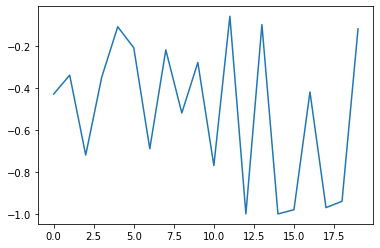

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.show()
#the result of loss function seems to be fluctuating, however at the end it decreases than initial loss.

In [ ]:
'''
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0000001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
model.train()
batch_tot=5
for batch in range(batch_tot):
  for epoch in range(epochs):
    total_loss = []
    optimizer.zero_grad()
    for img_path,target_x in data_dict.items():
        # Forward pass
        img_arr= cv2.imread(img_path)
        resized_arr= cv2.resize(img_arr,(img_size,img_size))
        resized_arr= cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
        data=torch.from_numpy(resized_arr)
        data=torch.unsqueeze(data,0)
        data=torch.unsqueeze(data,0)
        data=data.type(torch.float32)
        output = model(data)
        target=torch.ones(1,dtype=torch.long)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward(retain_graph=True)
    # Optimize the weights
    optimizer.step()
    total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))'''